In [2]:
import os 
import itertools  

import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
# Disable XLA globally
tf.config.optimizer.set_jit(False)
from tensorflow import keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D , Flatten , Dense, Activation , Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

****Read Data****

 The directory structure of the skin cancer dataset, where each subfolder corresponds to a different class (e.g., benign, malignant). It collects the file paths of the images and their corresponding labels based on the folder names. These are stored in two pandas Series (Fseries for file paths and Lseries for labels) and then combined into a DataFrame (train_df). T

In [3]:
train_dir = "/kaggle/input/skin-cancer-dataset/train"

filepaths = []
labels = []

folds = os.listdir(train_dir)

for fold in folds:
    foldpaths = os.path.join(train_dir, fold)
    filelists = os.listdir(foldpaths)
    
    for file in filelists:
        filepath= os.path.join(foldpaths, file)
        
        filepaths.append(filepath)
        labels.append(fold)
        
Fseries = pd.Series(filepaths, name= 'Filepath')
Lseries = pd.Series(labels, name='Label')

train_df = pd.concat([Fseries, Lseries], axis=1)
train_df.head()

,Filepath,Label
0,/kaggle/input/skin-cancer-dataset/train/Benign...,Benign
1,/kaggle/input/skin-cancer-dataset/train/Benign...,Benign
2,/kaggle/input/skin-cancer-dataset/train/Benign...,Benign
3,/kaggle/input/skin-cancer-dataset/train/Benign...,Benign
4,/kaggle/input/skin-cancer-dataset/train/Benign...,Benign


In [4]:
test_dir = "/kaggle/input/skin-cancer-dataset/test"

filepaths = []
labels = []

folds = os.listdir(test_dir)

for fold in folds:
    foldpaths = os.path.join(test_dir, fold)
    filelists = os.listdir(foldpaths)
    
    for file in filelists:
        filepath= os.path.join(foldpaths, file)
        
        filepaths.append(filepath)
        labels.append(fold)
        
Fseries = pd.Series(filepaths, name= 'Filepath')
Lseries = pd.Series(labels, name='Label')

dummy_df = pd.concat([Fseries, Lseries], axis=1)
dummy_df.head()

,Filepath,Label
0,/kaggle/input/skin-cancer-dataset/test/Benign/...,Benign
1,/kaggle/input/skin-cancer-dataset/test/Benign/...,Benign
2,/kaggle/input/skin-cancer-dataset/test/Benign/...,Benign
3,/kaggle/input/skin-cancer-dataset/test/Benign/...,Benign
4,/kaggle/input/skin-cancer-dataset/test/Benign/...,Benign


****Split Dataset to Train,Valid,Test****

In [5]:
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle= True, random_state= 42,
                                    stratify= dummy_df['Label'])

****Create image data generator****

ImageDataGenerator to create data pipelines for training, validation, and testing datasets. It reads image file paths and labels from the provided DataFrames (train_df, valid_df, test_df) and preprocesses the images by resizing them to 224x224 pixels and batching them in groups of 10. The images are loaded in RGB format, and the labels are one-hot encoded for a categorical classification task. 

In [6]:
batch_size = 10
image_size = (224,224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col="Filepath", y_col="Label",
                                   class_mode ="categorical", color="rgb",
                                   batch_size= batch_size, target_size = image_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col="Filepath", y_col="Label",
                                   class_mode ="categorical", color="rgb",
                                   batch_size= batch_size, target_size = image_size)

test_gen = gen.flow_from_dataframe(test_df, x_col="Filepath", y_col="Label",
                                   class_mode ="categorical", color="rgb",
                                   batch_size= batch_size, target_size = image_size)

Found 11879 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


****Show sample from data****

 A batch of 9 images from the training dataset, along with their corresponding class labels. It scales the images to the range (0-255) for display, retrieves the predicted class index using argmax, and maps it to the class name using the generator's class indices. Each image is displayed with its class label in blue color, arranged in a 3x3 grid for clear visualization. This helps verify data loading and the correctness of labels

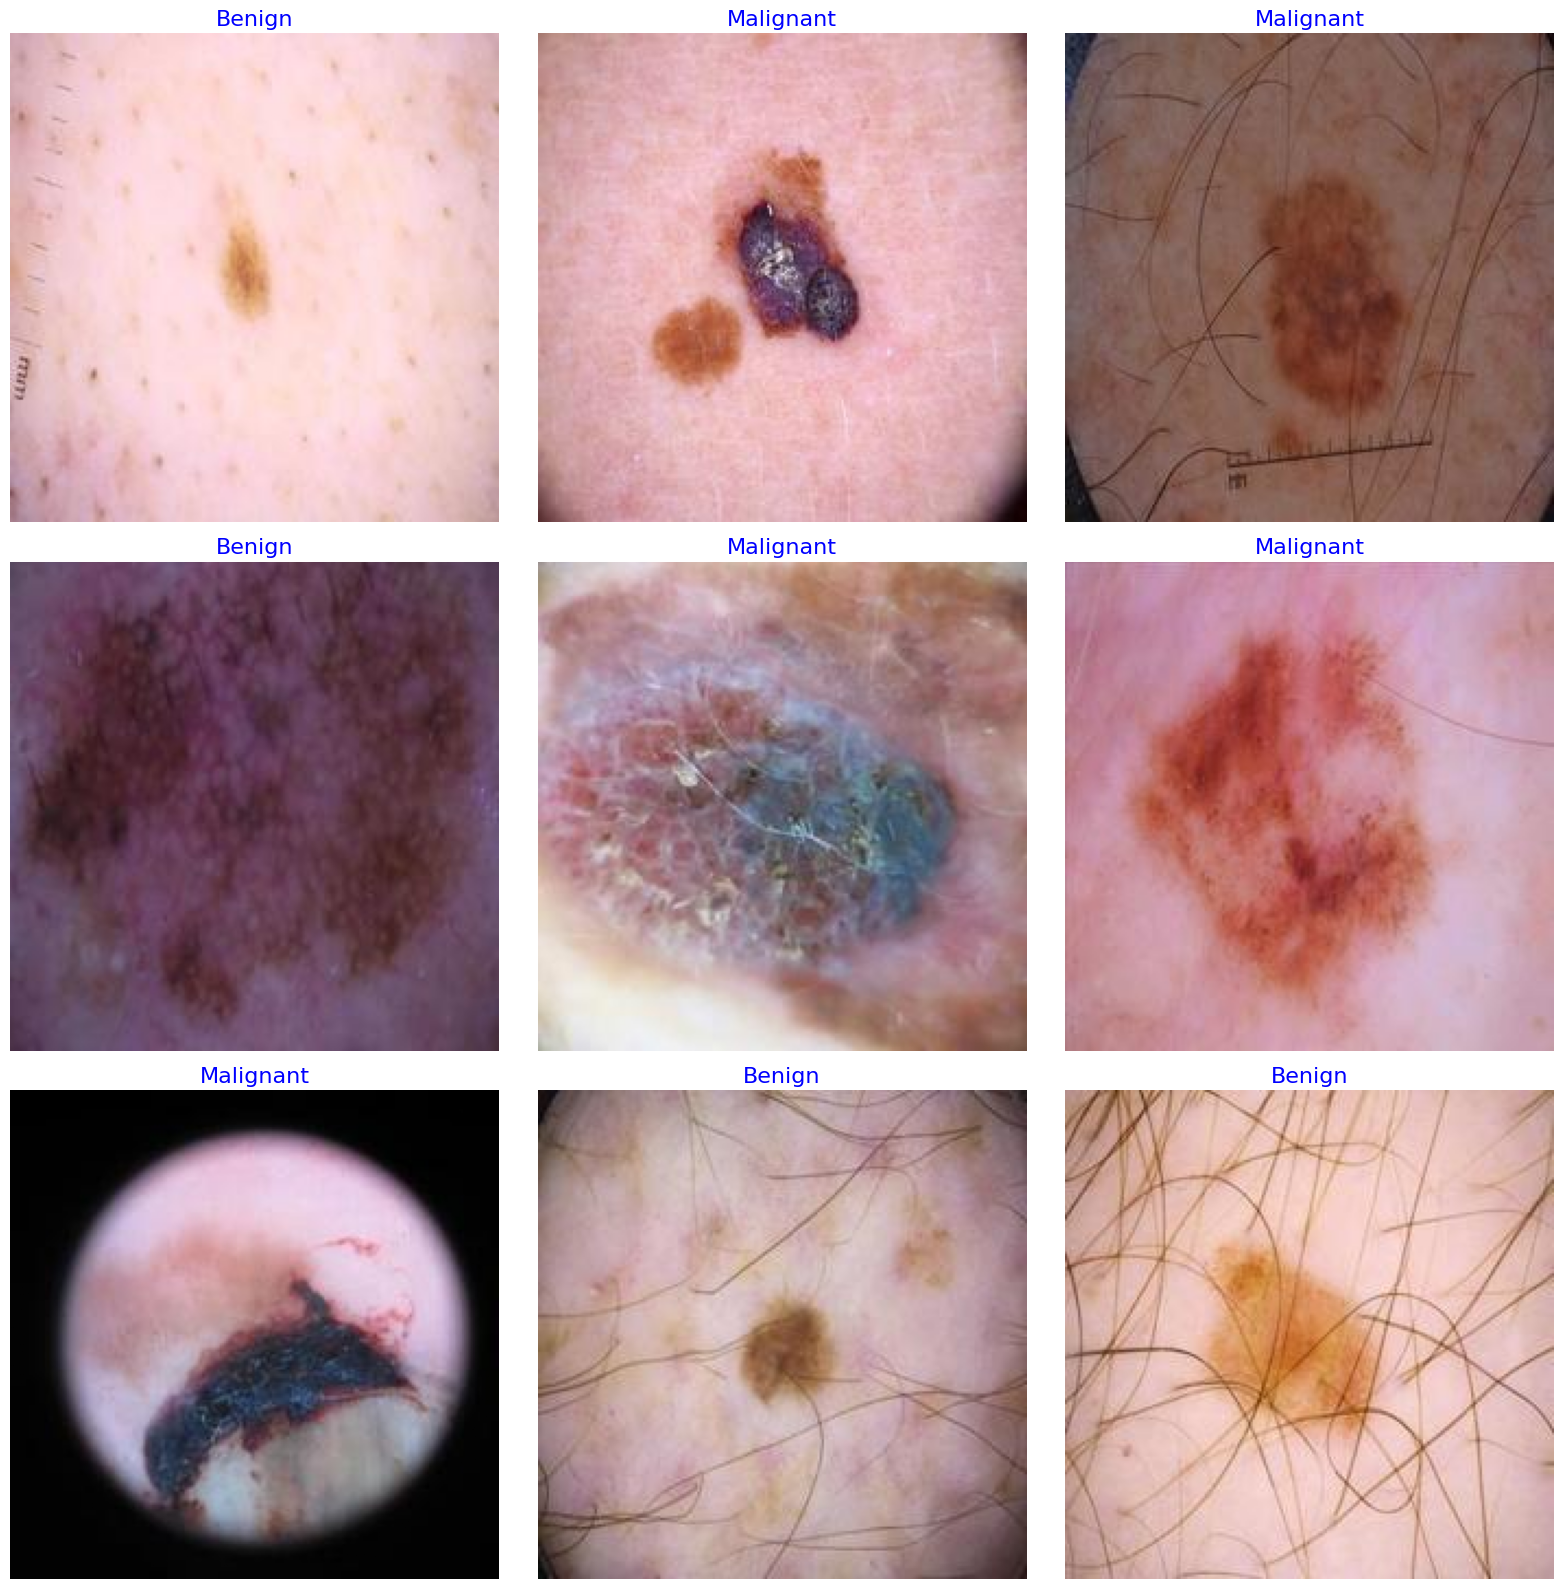

In [7]:
gen_dict = train_gen.class_indices
classes_name = list(gen_dict.keys())

images, labels = next(train_gen)


plt.figure(figsize= (16, 16))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes_name[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

****CNN Model Structure****

Convolutional Neural Network (CNN) architecture for a multi-class image classification task. It consists of five convolutional blocks with Conv2D layers (32 to 512 filters), BatchNormalization, MaxPooling2D, and Dropout layers to reduce overfitting and improve generalization. The network flattens the output and uses fully connected Dense layers with dropout for further learning before the final softmax activation predicts class probabilities. The model is designed to handle input images of size 224x224x3 and outputs predictions for the number of classes derived from the dataset.

In [8]:
channels = 3
image_size = (224,224)
image_shape =(image_size[0], image_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters= 32, kernel_size = (3,3), padding='same', activation = 'relu', input_shape = image_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters= 64, kernel_size = (3,3), padding='same', activation = 'relu'),
    Conv2D(filters= 64, kernel_size = (3,3), padding='same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 128 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding='same', activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 256 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding='same', activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 512 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding='same', activation='relu'),
    Dropout(rate=0.3),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(512, activation="relu"),
    Dropout(rate=0.3),
    Dense(256, activation="relu"),
    Dropout(rate=0.3),
    Dense(128, activation="relu"),
    Dropout(rate=0.45),
    Dense(class_count, activation="softmax")
])

In [9]:
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 512)    │             

 Total params: 20,912,770 (79.78 MB)

 Trainable params: 20,861,634 (79.58 MB)

 Non-trainable params: 51,136 (199.75 KB)

****Train Model****

In [10]:
history = model.fit(train_gen, epochs= 25, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/25


I0000 00:00:1734409641.563650      70 service.cc:145] XLA service 0x7d318800a350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734409641.563739      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/1188 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.5611 - loss: 1.0843   

I0000 00:00:1734409655.324359      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 80s 52ms/step - accuracy: 0.6830 - loss: 1.5144 - val_accuracy: 0.8340 - val_loss: 0.6827
Epoch 2/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.7697 - loss: 0.5206 - val_accuracy: 0.8140 - val_loss: 0.6372
Epoch 3/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.8073 - loss: 0.4446 - val_accuracy: 0.7500 - val_loss: 0.4810
Epoch 4/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.8233 - loss: 0.4169 - val_accuracy: 0.5450 - val_loss: 0.8999
Epoch 5/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.8295 - loss: 0.3940 - val_accuracy: 0.7040 - val_loss: 0.5545
Epoch 6/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.8397 - loss: 0.3793 - val_accuracy: 0.8640 - val_loss: 0.4372
Epoch 7/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.8416 - loss: 0.3703 - val_accuracy: 0.6870 - val_loss: 0.5026
Epoch 8/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.8482 - loss: 0.36

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

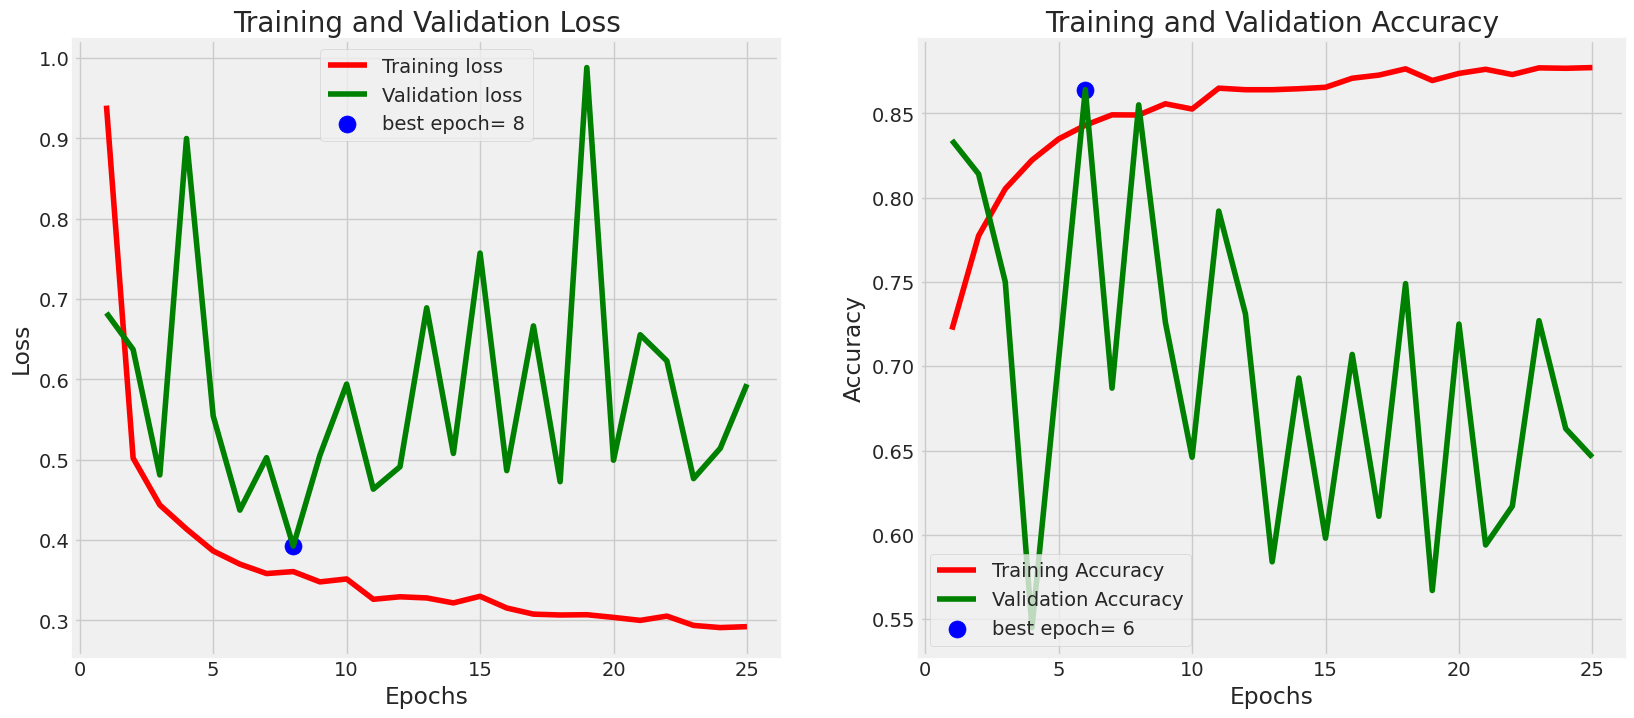

In [12]:
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

The training history of a deep learning model by plotting training and validation loss and accuracy over epochs. It uses a side-by-side subplot layout to display two graphs: one for loss and the other for accuracy. Key points like the lowest validation loss and the highest validation accuracy are highlighted with blue scatter points for better interpretation. This helps analyze model performance and identify potential overfitting or underfitting.

****Evaluate the CNN model****

the trained model's performance on the training, validation, and test datasets using their respective data generators (train_gen, valid_gen, test_gen). It calculates the loss and accuracy for each dataset and prints the results for comparison. This helps assess how well the model has learned (train performance), how it generalizes to unseen validation data, and its performance on the test set for final evaluation.

In [13]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7699 - loss: 0.4309
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6176 - loss: 0.6592
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6761 - loss: 0.5110
Train Loss:  0.45037686824798584
Train Accuracy:  0.7654684782028198
--------------------
Validation Loss:  0.5939844846725464
Validation Accuracy:  0.6460000276565552
--------------------
Test Loss:  0.5399072170257568
Test Accuracy:  0.6549999713897705


In [14]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1) 

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm



array([[399, 101],
       [440,  60]])

In [16]:
print(classification_report(test_gen.classes, y_pred,
                            target_names= classes))

              precision    recall  f1-score   support

      Benign       0.48      0.80      0.60       500
   Malignant       0.37      0.12      0.18       500

    accuracy                           0.46      1000
   macro avg       0.42      0.46      0.39      1000
weighted avg       0.42      0.46      0.39      1000



The model achieves an overall accuracy of 46% on the test data. For the Benign class, the precision is 0.48 with a recall of 0.80, indicating the model is better at identifying benign cases but lacks precision. For the Malignant class, the precision is 0.37 with a low recall of 0.12, meaning the model struggles to detect malignant cases. The weighted average F1-score of 0.39 highlights the model's limited performance, especially in handling class imbalance or distinguishing malignant samples effectively.

****Fine tuning using VGG16****

a transfer learning model using the VGG16 architecture pre-trained on the ImageNet dataset. The base model excludes its top layers (include_top=False) and uses average pooling to extract features, with its weights frozen to prevent retraining. A custom fully connected head with Batch Normalization, dense layers (512, 256, 128 neurons), and Dropout is added for classification. The model is compiled with the Adamax optimizer, a learning rate of 0.0001, and uses categorical cross-entropy for multi-class classification.

In [17]:
channels = 3
image_size = (224,224)
image_shape =(image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model_base= keras.applications.VGG16(
    include_top = False,
    weights= "imagenet",
    input_shape= image_shape,
    pooling = 'avg'
)

model_base.trainable = False 

model2 = Sequential([
    model_base,
    BatchNormalization(),
 
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(rate=0.3, seed=123),
    Dense(class_count, activation="softmax")
])

model2.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.build(input_shape=(None, *image_shape))
model2.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,143,874 (57.77 MB)

 Trainable params: 428,162 (1.63 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model2.fit(train_gen, epochs= 30, verbose= 1,
                    validation_data = valid_gen, shuffle= True)

Epoch 1/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - accuracy: 0.7553 - loss: 0.5108 - val_accuracy: 0.8510 - val_loss: 0.3551
Epoch 2/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8453 - loss: 0.3553 - val_accuracy: 0.8860 - val_loss: 0.2995
Epoch 3/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8465 - loss: 0.3440 - val_accuracy: 0.8790 - val_loss: 0.2934
Epoch 4/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8623 - loss: 0.3215 - val_accuracy: 0.8870 - val_loss: 0.2767
Epoch 5/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8707 - loss: 0.3095 - val_accuracy: 0.8860 - val_loss: 0.2743
Epoch 6/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8778 - loss: 0.2873 - val_accuracy: 0.8870 - val_loss: 0.2760
Epoch 7/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8800 - loss: 0.2827 - val_accuracy: 0.9060 - val_loss: 0.2503
Epoch 8/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8881 -

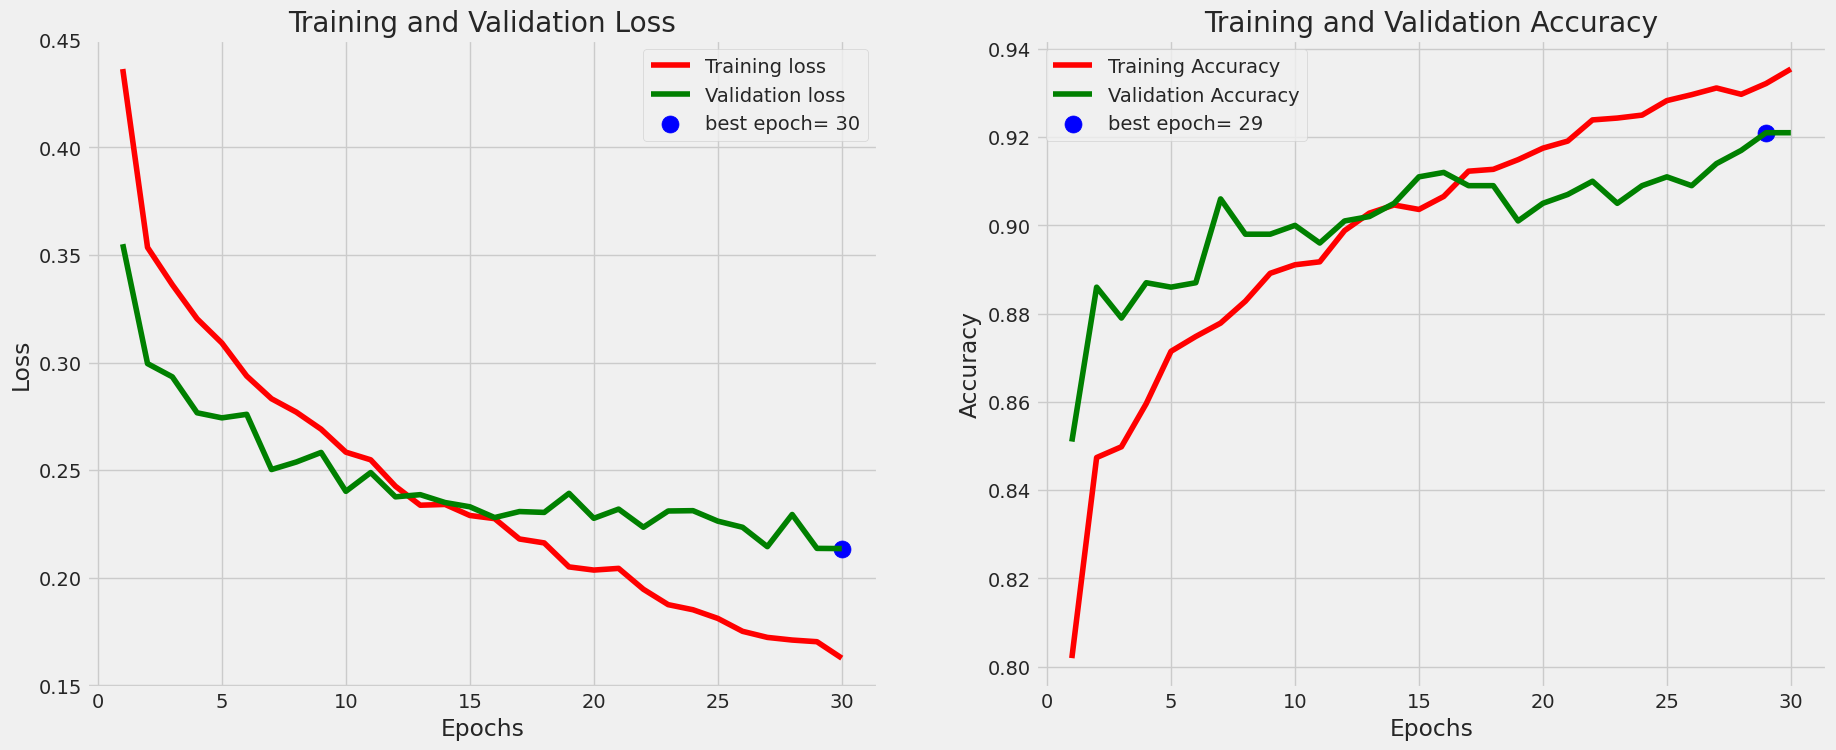

In [20]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


the training and validation loss, as well as accuracy, over epochs to visualize the model's performance during training. It highlights the epochs with the lowest validation loss and the highest validation accuracy using blue markers. The training and validation curves are displayed side by side to compare the model's learning and generalization behavior. This helps identify overfitting or underfitting and track the model's progress throughout the training process.








In [21]:
train_score = model2.evaluate(train_gen, verbose= 1)
valid_score = model2.evaluate(valid_gen, verbose= 1)
test_score = model2.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.9480 - loss: 0.1328
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9292 - loss: 0.1946
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8947 - loss: 0.2647
Train Loss:  0.13182084262371063
Train Accuracy:  0.9506692290306091
--------------------
Validation Loss:  0.2135680764913559
Validation Accuracy:  0.9210000038146973
--------------------
Test Loss:  0.2456081509590149
Test Accuracy:  0.9039999842643738
